## EDA

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from wordcloud import WordCloud

In [3]:
df = pd.read_csv('../data/interim.csv', index_col=0)
df.shape

(18963, 2)

In [4]:
df.nunique()

complaint_what_happened    18824
ticket_classification         78
dtype: int64

En nuestro dataset hay 2 columnas, que fueron las que seleccionamos como relevantes para nuestro propósito, y 18,963 registros, aunque parece ser que algunas se repiten, ya que hay 18,824 instancias únicas, que es mayor al número de registros totales.

Podemos ver que hay 78 categorías distintas a predecir, es decir, las 18,963 quejas que hay, cada una de ellas pertenecerá a una categoría.

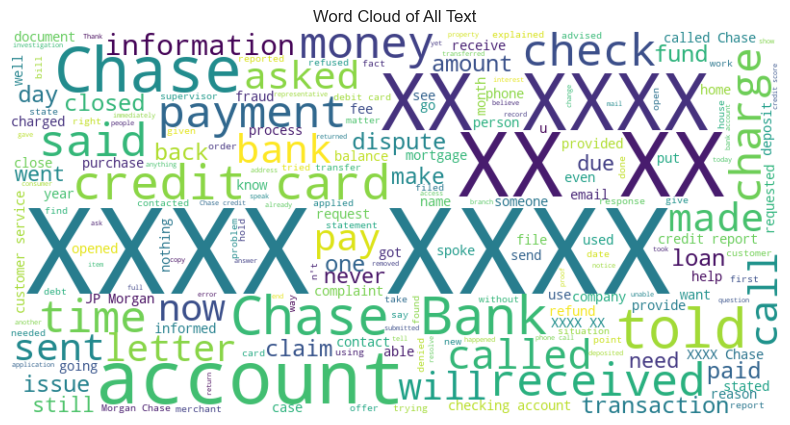

In [5]:
# Word cloud for all text
all_text = ' '.join(df['complaint_what_happened'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

Al haber instancias de 'XXXX' o 'XX', procederemos a quitar esto de la columna.

In [6]:
def remove_sensitive_info(text):
    if isinstance(text, str):  # Ensure the input is a string
        return re.sub(r'X{2,}', '', text)  # Remove XX, XXX, XXXX
    return text

df['complaint_what_happened'] = df['complaint_what_happened'].apply(remove_sensitive_info)

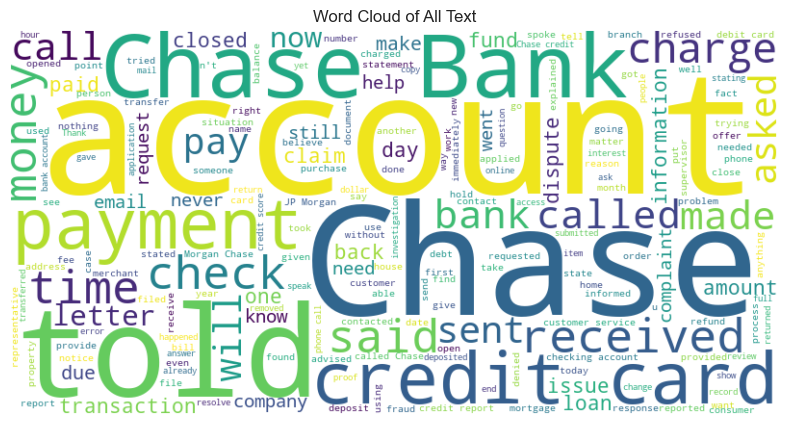

In [7]:
# Word cloud for all text
all_text = ' '.join(df['complaint_what_happened'].astype(str))
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of All Text')
plt.show()

Ahora sí, podemos ver las palabras más comunes en nuestra sección de quejas.

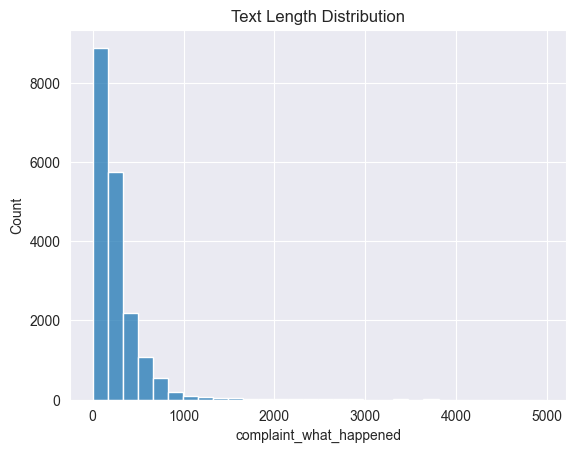

In [8]:
# Text length analysis
length = df.copy()
length['complaint_what_happened'] = length['complaint_what_happened'].apply(lambda x: len(x.split()))
sns.histplot(length['complaint_what_happened'], bins=30)
plt.title('Text Length Distribution')
plt.show()

Aquí podemos apreciar que la mayoría de quejas son largas, contienen mucho texto.

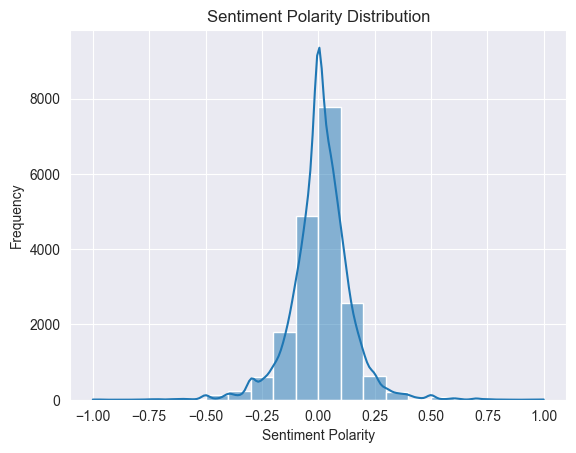

In [9]:
from textblob import TextBlob

def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns value between -1 (negative) and 1 (positive)

sentiments = df.copy()

sentiments['sentiment'] = sentiments['complaint_what_happened'].dropna().astype(str).apply(get_sentiment)

# Plot
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(sentiments['sentiment'], bins=20, kde=True)
plt.title('Sentiment Polarity Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()


Aquí usamos la librería de textblob para realizar un breve análisis de sentimientos, en donde el -1 indica un sentimiento de negatividad, mientras que el 1 indica un sentimiento de positividad.

Como podemos observar, la mayoría de quejas se encuentran dentro del rango de -0.25 a 0.25, lo cual indica que la mayoría de quejas son neutrales.


In [14]:
pd.options.display.max_rows = 4000
print(df['ticket_classification'].value_counts())

ticket_classification
Credit card or prepaid card+General-purpose credit card or charge card                                         4918
Checking or savings account+Checking account                                                                   3788
Credit reporting, credit repair services, or other personal consumer reports+Credit reporting                  2011
Bank account or service+Checking account                                                                       1242
Mortgage+Conventional home mortgage                                                                             955
Mortgage+Conventional fixed mortgage                                                                            785
Mortgage+FHA mortgage                                                                                           496
Debt collection+Credit card debt                                                                                427
Money transfer, virtual currency, or money service

Al contar con 78 categorías distintas, imprimimos las veces que se repite cada una, y nos encontramos con que hay varias categorías que sólo aparecen 1 vez. Procederemos a establecer un threshold para que sólo se tomen en cuenta las categorías con un mínimo de 100 apariciones, esto para reducir el ruido a la hora de entrenar los modelos seleccionados.

In [15]:
category_counts = df['ticket_classification'].value_counts()
# Filter categories that meet the threshold
filters = category_counts[category_counts >= 100].index
df = df[df['ticket_classification'].isin(filters)]

In [17]:
df['ticket_classification'].nunique()

24

Con esto, reducimos el número de categorías de 78 a 24. Ahora pasaremos al preprocesamiento para pasar el dataset a los modelos.

### Preprocesamiento